# Connect4 PPQ model

By LaughingSkull as new RL agent for my game COnnect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php

PPO (Proximal Policy Optimization)

* A policy-based reinforcement learning method.

* Uses a neural network to directly learn the policy: outputs a probability distribution over actions for given states.

* Optimizes with clipped policy gradients to prevent overly large, destabilizing updates.

* Balances exploration and exploitation via stochastic action sampling.

* Typically more stable and sample-efficient than vanilla policy gradient methods, while simpler to implement than TRPO.

Version log:
* 0.9 restart
    * using DQN lessons learned as template 

## Links, learning from
[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
[https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/](https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>


## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pprint;
import pandas as pd
import os
from IPython.display import display, clear_output

import warnings

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["PYTHONHASHSEED"] = str(SEED)

## Constants

In [3]:
log_every_x_episode = 100
plot_interval = 10 

In [4]:
LOG_DIR ="Logs/PPQ/"
MODEL_DIR ="Models/PPQ/"
PLOTS = "Plots/PPQ/"

## Custom imports

In [5]:
from C4.connect4_env import Connect4Env
from C4.connect4_lookahead import Connect4Lookahead
from PPO.ppo_training_phases_config import TRAINING_PHASES
from PPO.actor_critic import ActorCritic
from PPO.ppo_buffer import PPOBuffer, PPOHyperParams
from PPO.ppo_update import ppo_update, PPOUpdateCfg
from C4.connect4_board_display import Connect4_BoardDisplayer
from C4.plot_phase_summary import plot_phase_summary
from PPO.ppo_utilities import select_opponent_action, is_draw, PhaseTracker, display_phases_table, params_for_phase   
from PPO.ppo_live_plot import plot_live_training_ppo
from PPO.ppo_summary import (
    init_summary_stats, log_summary_stats_ppo,
    save_summary_stats_excel, sanitize_for_plot, summary_stats_df
)
from PPO.checkpoint import save_checkpoint, load_checkpoint

Lookahead = Connect4Lookahead()
summary_stats = init_summary_stats()

# Training phases

In [6]:
PHASES = PhaseTracker(TRAINING_PHASES)
display_phases_table(TRAINING_PHASES)

phase,start_ep,end_ep,duration,lookahead,length,lr,clip,entropy,epochs
Random1,1,500,500,0,500,0.00030,0.20,0.010,4
SelfPlay_Random,501,1000,500,-1,1000,0.00015,0.12,0.007,4
L1_Intro,1001,1750,750,1,1750,0.00030,0.20,0.010,4
Random2,1751,2000,250,0,2000,0.00030,0.20,0.010,4
L1_Consol,2001,3000,1000,1,3000,0.00020,0.18,0.009,4
Random3,3001,3250,250,0,3250,0.00020,0.18,0.009,4
L2_Intro,3251,4000,750,2,4000,0.00020,0.15,0.008,4
Random4,4001,4250,250,0,4250,0.00020,0.15,0.008,4
L2_Consol,4251,5250,1000,2,5250,0.00015,0.12,0.007,4
SelfPlay_L1L2,5251,5750,500,-1,5750,0.00015,0.12,0.007,4


# Training session name


In [7]:
number_episodes = 1500 
lookahead_depth = 7  # prophet = 7
tag = "SelfPlay sanity"
TRAINING_SESSION = f"PPQ-{number_episodes}-{tag}"
begin_start_time = time.time()
print("Start training session", TRAINING_SESSION)

Start training session PPQ-1500-SelfPlay sanity


# PPO

In [8]:
ppo_model = ActorCritic(action_dim=7).to(DEVICE)
summary(ppo_model, input_size=(1, 1, 6, 7))

Layer (type:depth-idx)                   Output Shape              Param #
ActorCritic                              [1, 7]                    --
├─Conv2d: 1-1                            [1, 32, 6, 7]             320
├─Conv2d: 1-2                            [1, 64, 5, 6]             32,832
├─Flatten: 1-3                           [1, 1920]                 --
├─Linear: 1-4                            [1, 128]                  245,888
├─Linear: 1-5                            [1, 7]                    903
├─Linear: 1-6                            [1, 1]                    129
Total params: 280,072
Trainable params: 280,072
Non-trainable params: 0
Total mult-adds (M): 1.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.12
Estimated Total Size (MB): 1.15

## Training Loop

In [9]:
# --- Logging / histories ---
win_history = []  

ppo_metrics_history = {
    "episodes": [],
    "loss_pi": [],
    "loss_v": [],
    "entropy": [],
    "approx_kl": [],
    "clip_frac": [],
    "explained_variance": [],
}

update_idx = 0
steps_collected = 0
reward_history = []              # per-episode total reward
win_count = loss_count = draw_count = 0
wins_hist, losses_hist, draws_hist = [], [], []

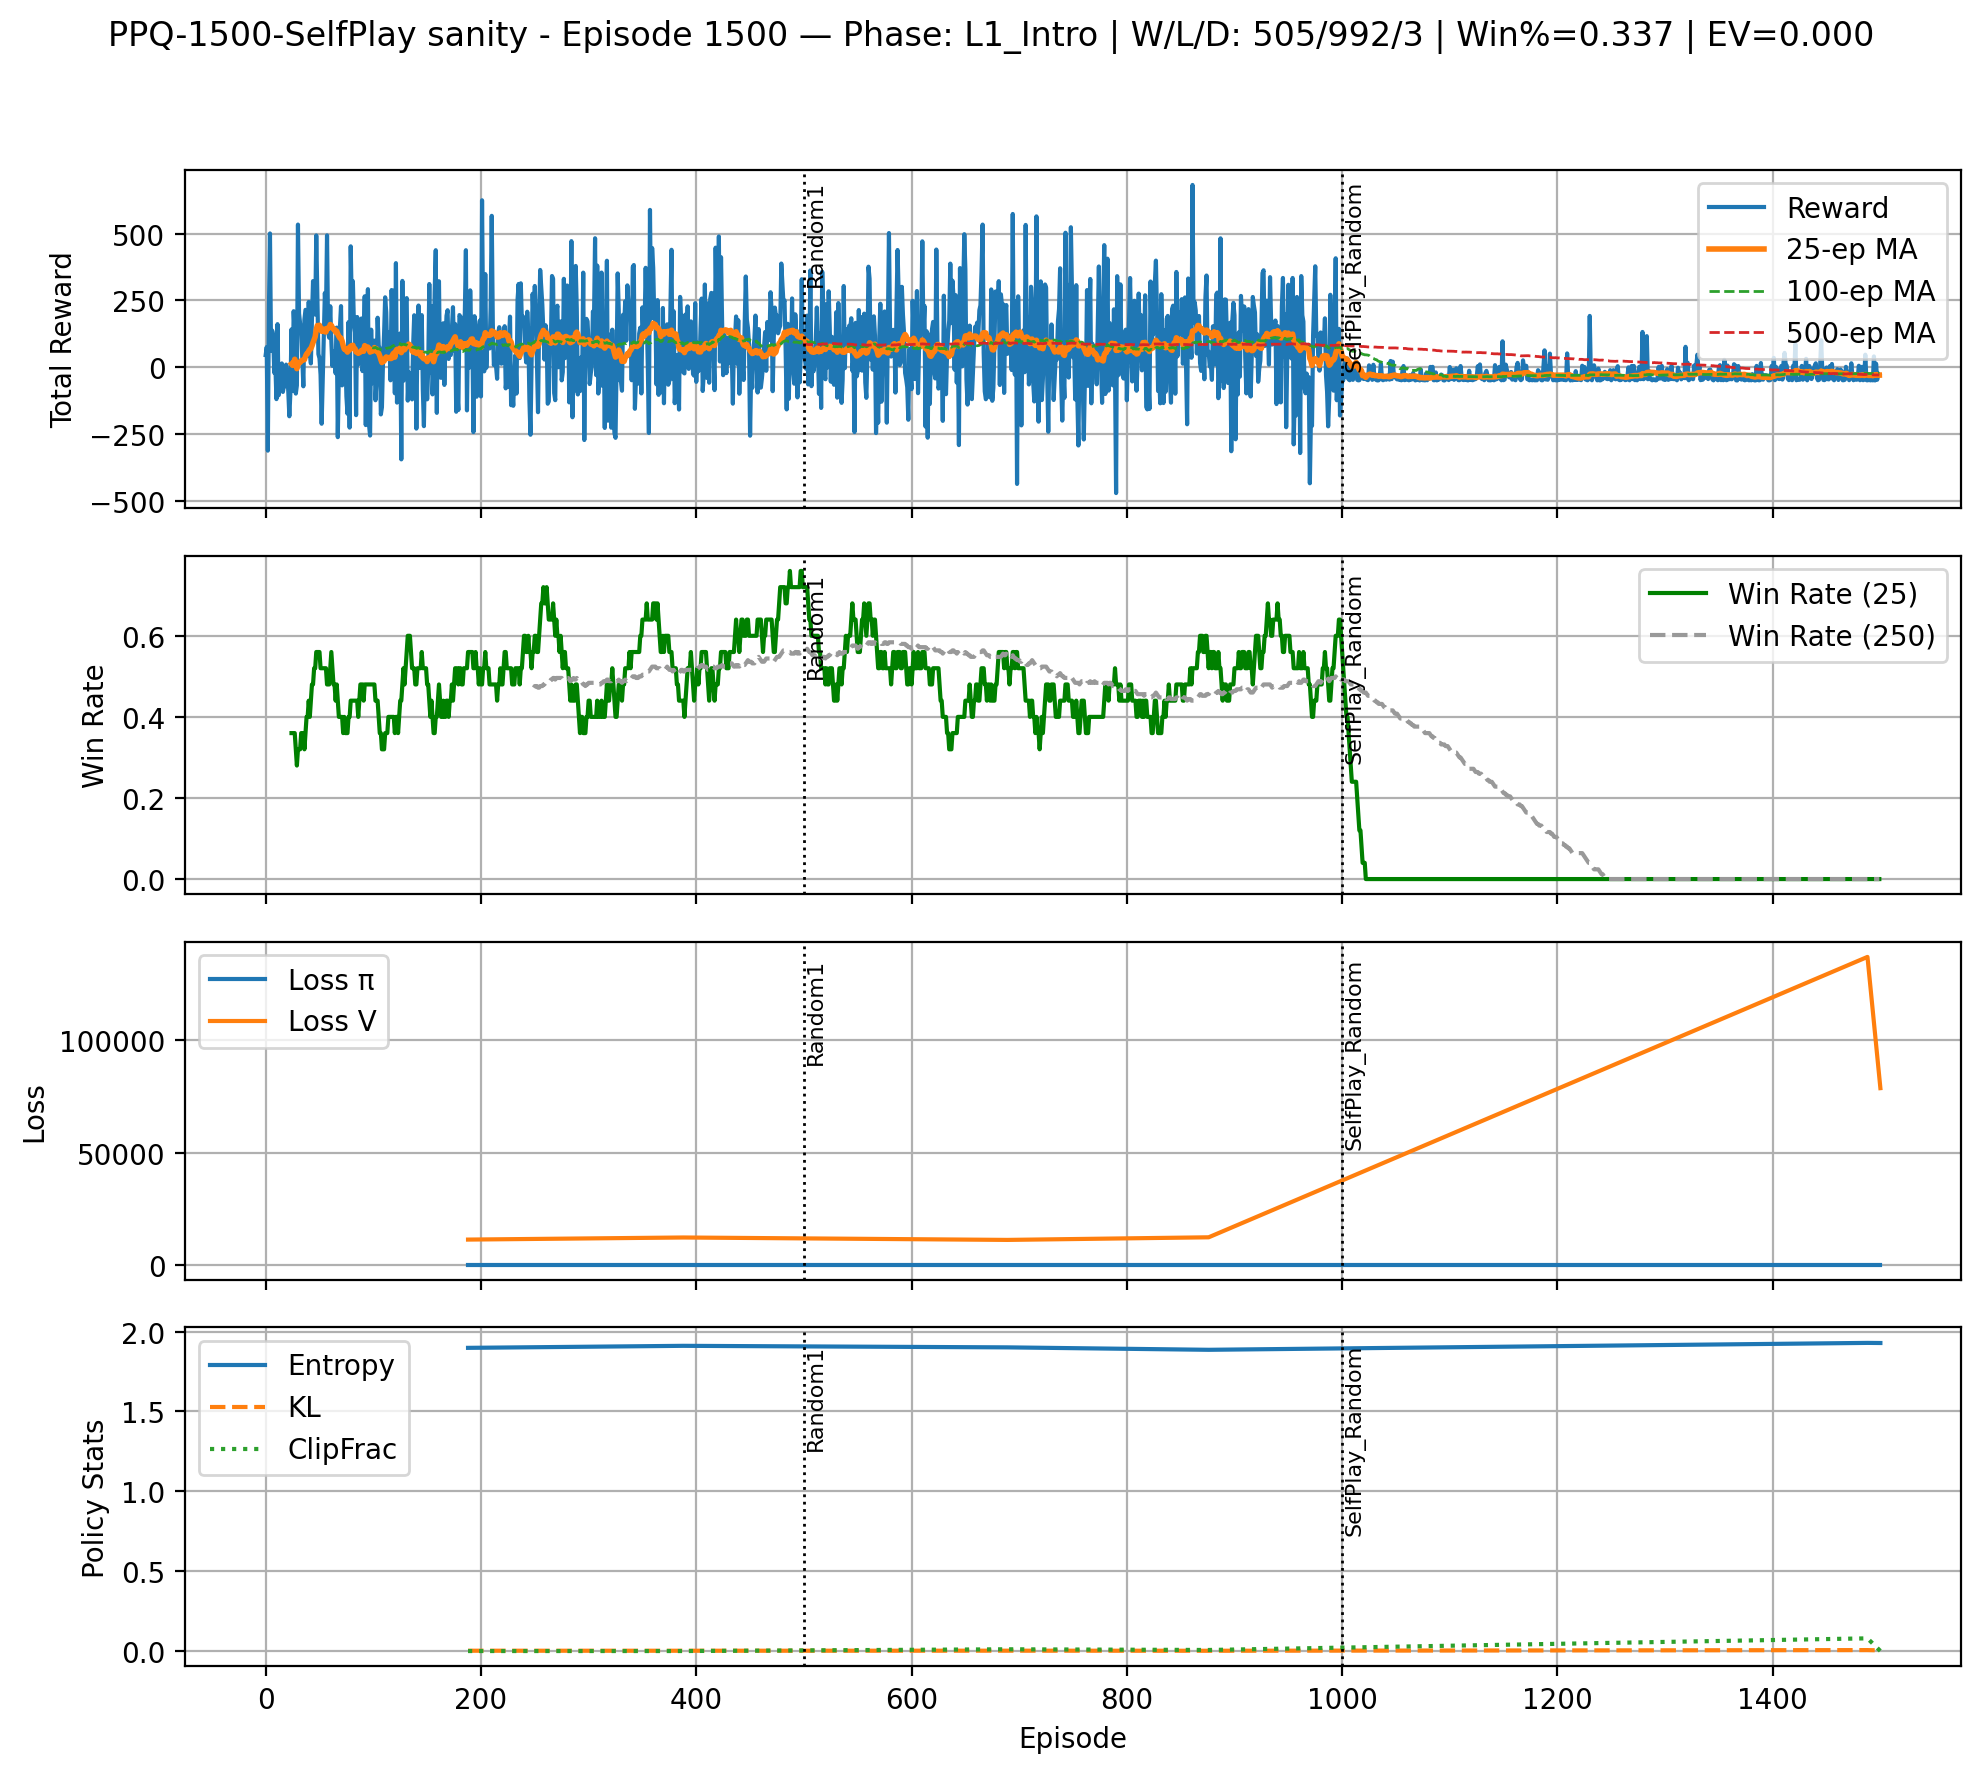

[Saved] Plots/PPQ/PPQ-1500-SelfPlay sanity__complete_training_plot.png
Training finished in 5.8 min


In [10]:
# === PPO TRAINING LOOP (episode-driven, with live plotting) ===

# --- Hyperparameters (global defaults; phases may override) ---
STEPS_PER_UPDATE    = 2048           # agent decisions per PPO update
LEARNING_RATE       = 3e-4
TEMPERATURE         = 1.0            # 0.0 = greedy sampling
ATTR_LOSS_TO_LAST   = True           # attribute opponent's terminal win to our last move
CLEAR_BUFFER_ON_PHASE_CHANGE = True  # ### CHANGED: avoid leaking rollouts across phases

# --- Env / Policy / Optimizer / Buffer ---
env     = Connect4Env()
policy  = ActorCritic(action_dim=7).to(DEVICE)
optim   = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE, eps=1e-5)

hparams = PPOHyperParams(gamma=0.99, gae_lambda=0.95, normalize_adv=True)
buffer  = PPOBuffer(capacity=STEPS_PER_UPDATE * 2, action_dim=7, hparams=hparams)

cfg     = PPOUpdateCfg(
    epochs=4, batch_size=256,
    clip_range=0.20, vf_clip_range=0.20,
    ent_coef=0.01, vf_coef=0.5,
    max_grad_norm=0.5, target_kl=0.03
)

start_time = time.time()

# for final bootstrapping if we stop mid-episode
_state_for_bootstrap = None
_next_player_for_bootstrap = None
_done_for_bootstrap = True  # assume terminal unless proven otherwise
current_phase_name = None
lookahead_depth = None  # ### CHANGED: keep current lookahead here

with tqdm(total=number_episodes, desc="Episodes") as epbar:
    for episode in range(1, number_episodes + 1):
        phase_info, changed = PHASES.start_episode(episode)
        current_phase_name = phase_info.name

        if changed:
            # apply per-phase opponent & PPO params
            lookahead_depth = phase_info.lookahead  # None => Random; int => depth; "self" if you support self-play
            phase_params = params_for_phase(current_phase_name, cfg)
            # Hot-swap optimizer LR
            for g in optim.param_groups:
                g["lr"] = phase_params["lr"]
            # Hot-swap PPO cfg knobs
            cfg.clip_range     = phase_params["clip"]
            cfg.ent_coef       = phase_params["entropy"]
            cfg.epochs         = phase_params["epochs"]
            cfg.target_kl      = phase_params["target_kl"]
            cfg.vf_coef        = phase_params["vf_coef"]
            cfg.vf_clip_range  = phase_params["vf_clip"]
            cfg.batch_size     = phase_params["batch_size"]
            cfg.max_grad_norm  = phase_params["max_grad_norm"]

            if CLEAR_BUFFER_ON_PHASE_CHANGE:
                buffer.clear()
                steps_collected = 0
                last_agent_reward_index = None

            print(f"[Phase → {current_phase_name}] "
                  f"lookahead={lookahead_depth} | "
                  f"lr={phase_params['lr']} clip={cfg.clip_range} entropy={cfg.ent_coef} "
                  f"epochs={cfg.epochs} tKL={cfg.target_kl} bs={cfg.batch_size}")

        # === Episode loop ===
        state = env.reset()
        ep_return = 0.0
        done = False
        last_agent_reward_index = None
        episode_win_flag = 0  # 1 if agent wins

        # choose who starts explicitly: +1 agent, -1 opponent
        next_player = random.choice([1, -1])

        while not done:
            if next_player == 1:
                # --- Agent turn ---
                legal_actions = env.available_actions()
                if not legal_actions:
                    draw_count += 1
                    done = True
                    break

                legal_mask = np.zeros(7, dtype=bool)
                legal_mask[legal_actions] = True

                action, logprob, value, _ = policy.act(
                    state.astype(np.float32), legal_actions, temperature=TEMPERATURE
                )
                env.current_player = 1
                next_state, reward, done = env.step(action)
                ep_return += reward

                buffer.add(
                    state_np=state, action=action, logprob=logprob, value=value,
                    reward=reward, done=done, legal_mask_bool=legal_mask
                )
                last_agent_reward_index = len(buffer.rewards) - 1

                steps_collected += 1
                state = next_state

                if done:
                    if env.winner == 0:
                        draw_count += 1
                    elif env.winner == 1:
                        win_count += 1
                        episode_win_flag = 1
                    else:
                        loss_count += 1
                    break

                # opponent next
                next_player = -1

            else:
                # --- Opponent turn (-1) ---
                if lookahead_depth == "self":
                    # self-play: sample action from current policy for the opponent
                    opp_action, _, _, _ = policy.act(
                        state.astype(np.float32), env.available_actions(), temperature=TEMPERATURE
                    )
                else:
                    opp_action = select_opponent_action(state, player=-1, depth=lookahead_depth)

                if opp_action is None:
                    draw_count += 1
                    done = True
                    break

                env.current_player = -1
                state_after_opp, opp_reward, done = env.step(opp_action)

                if done:
                    if env.winner == 0:
                        draw_count += 1
                    elif env.winner == -1:
                        loss_count += 1
                        if ATTR_LOSS_TO_LAST and last_agent_reward_index is not None:
                            if 0 <= last_agent_reward_index < len(buffer.rewards):
                                buffer.rewards[last_agent_reward_index] += env.LOSS_PENALTY

                    state = state_after_opp
                    break

                state = state_after_opp
                next_player = 1

            # ---- Trigger PPO update when we've collected enough AGENT decisions ----
            if steps_collected >= STEPS_PER_UPDATE:
                update_idx += 1
                # bootstrap only if next mover would be AGENT
                last_done = True
                last_value = 0.0
                if next_player == 1:
                    with torch.no_grad():
                        _, v_boot = policy.forward(torch.from_numpy(state.astype(np.float32)))
                        last_value = float(v_boot.squeeze().item())
                    last_done = False

                buffer.compute_gae(last_value=last_value, last_done=last_done)
                metrics = ppo_update(policy, optim, buffer, cfg)

                # record update metrics at current episode index
                ppo_metrics_history["episodes"].append(episode)
                for k in ["loss_pi","loss_v","entropy","approx_kl","clip_frac","explained_variance"]:
                    ppo_metrics_history[k].append(metrics[k])

                # reset rollout buffer window
                buffer.clear()
                steps_collected = 0
                last_agent_reward_index = None

        # === episode ended ===
        reward_history.append(ep_return)
        wins_hist.append(win_count); losses_hist.append(loss_count); draws_hist.append(draw_count)
        win_history.append(episode_win_flag)   # (use 0.5 instead for draws if you prefer)
        epbar.update(1)

        # live plot at interval
        if episode % plot_interval == 0:
            plot_live_training_ppo(
                episode=episode,
                reward_history=reward_history,
                win_history=win_history,
                phase_name=current_phase_name,
                win_count=win_count, loss_count=loss_count, draw_count=draw_count,
                metrics_history=ppo_metrics_history,
                title=TRAINING_SESSION,
                phases=TRAINING_PHASES,
                save=False,
                save_path=PLOTS
            )

        if episode % log_every_x_episode == 0 or episode == 1:
            log_summary_stats_ppo(
                summary_stats,
                episode=episode,
                phase_name=current_phase_name,
                lookahead_depth=lookahead_depth,
                reward_history=reward_history,
                win_history=win_history,
                win_count=win_count, loss_count=loss_count, draw_count=draw_count,
                ppo_metrics_history=ppo_metrics_history,
                steps_per_update=STEPS_PER_UPDATE,
                lr=optim.param_groups[0]["lr"],
                # optional for DQN-style columns:
                epsilon=None,
                strategy_weights=None,
            )

        # keep state for potential final bootstrap if we stop mid-episode
        _state_for_bootstrap = state.copy()
        _next_player_for_bootstrap = next_player
        _done_for_bootstrap = done

# --- Final update on leftover samples (if any) ---
if len(buffer) > 0:
    last_done = True
    last_value = 0.0
    if not _done_for_bootstrap and _next_player_for_bootstrap == 1:
        with torch.no_grad():
            _, v_boot = policy.forward(torch.from_numpy(_state_for_bootstrap.astype(np.float32)))
            last_value = float(v_boot.squeeze().item())
        last_done = False

    buffer.compute_gae(last_value=last_value, last_done=last_done)
    metrics = ppo_update(policy, optim, buffer, cfg)

    # record final update metrics
    ppo_metrics_history["episodes"].append(episode)
    for k in ["loss_pi","loss_v","entropy","approx_kl","clip_frac","explained_variance"]:
        ppo_metrics_history[k].append(metrics[k])

# --- Final live plot (saved) ---
plot_live_training_ppo(
    episode=episode,
    reward_history=reward_history,
    win_history=win_history,
    phase_name=current_phase_name or PHASES.current_name,
    win_count=win_count, loss_count=loss_count, draw_count=draw_count,
    metrics_history=ppo_metrics_history,
    title=TRAINING_SESSION,
    phases=TRAINING_PHASES,
    save=True,
    save_path=PLOTS
)

print("Training finished in {:.1f} min".format((time.time() - start_time) / 60))

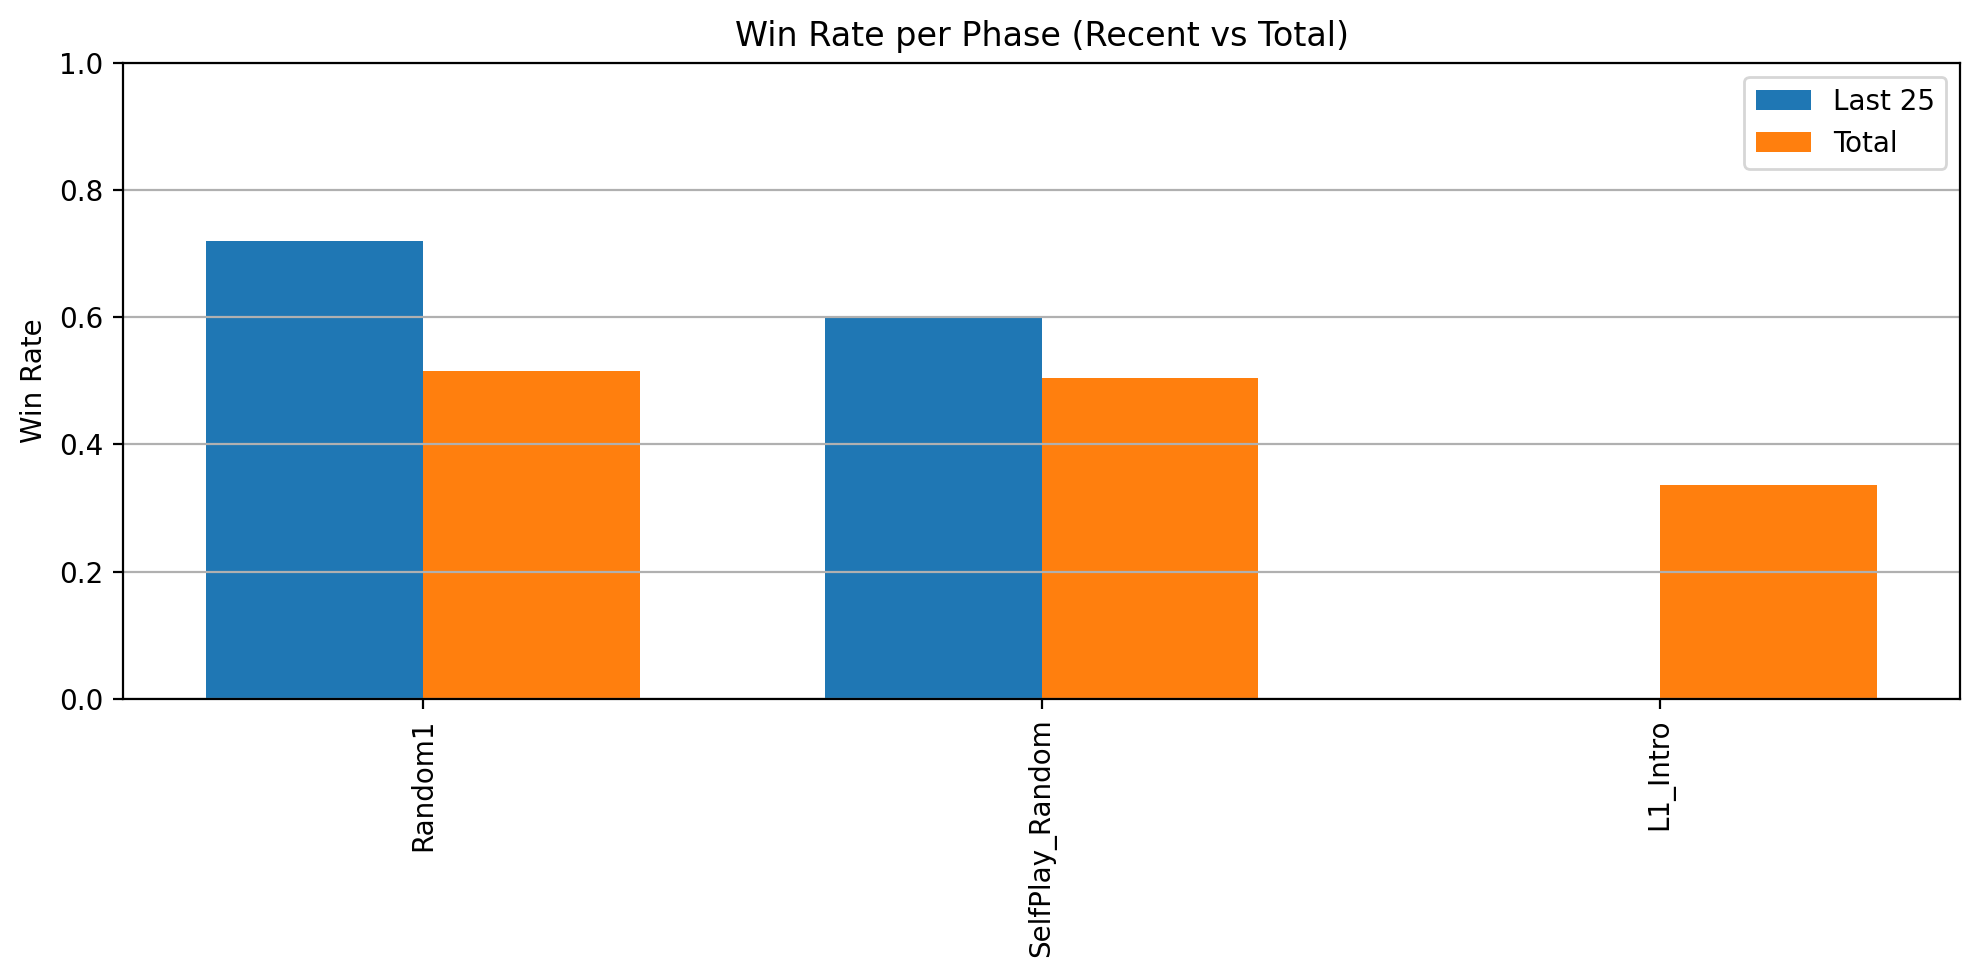

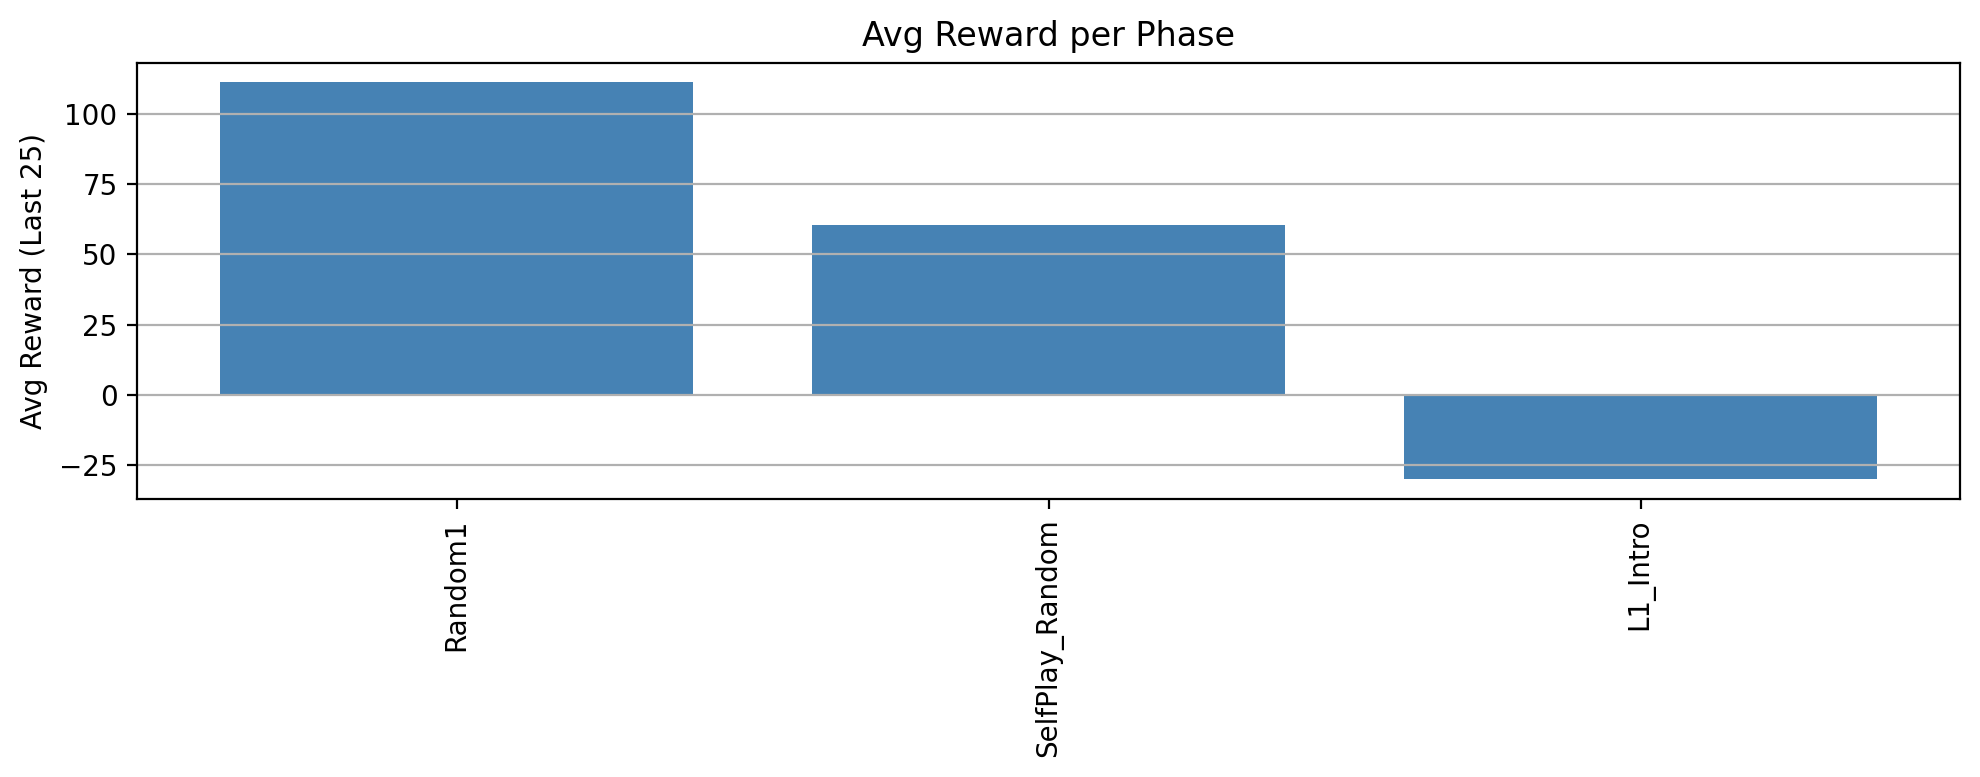

In [11]:
plot_phase_summary(summary_stats, TRAINING_PHASES)

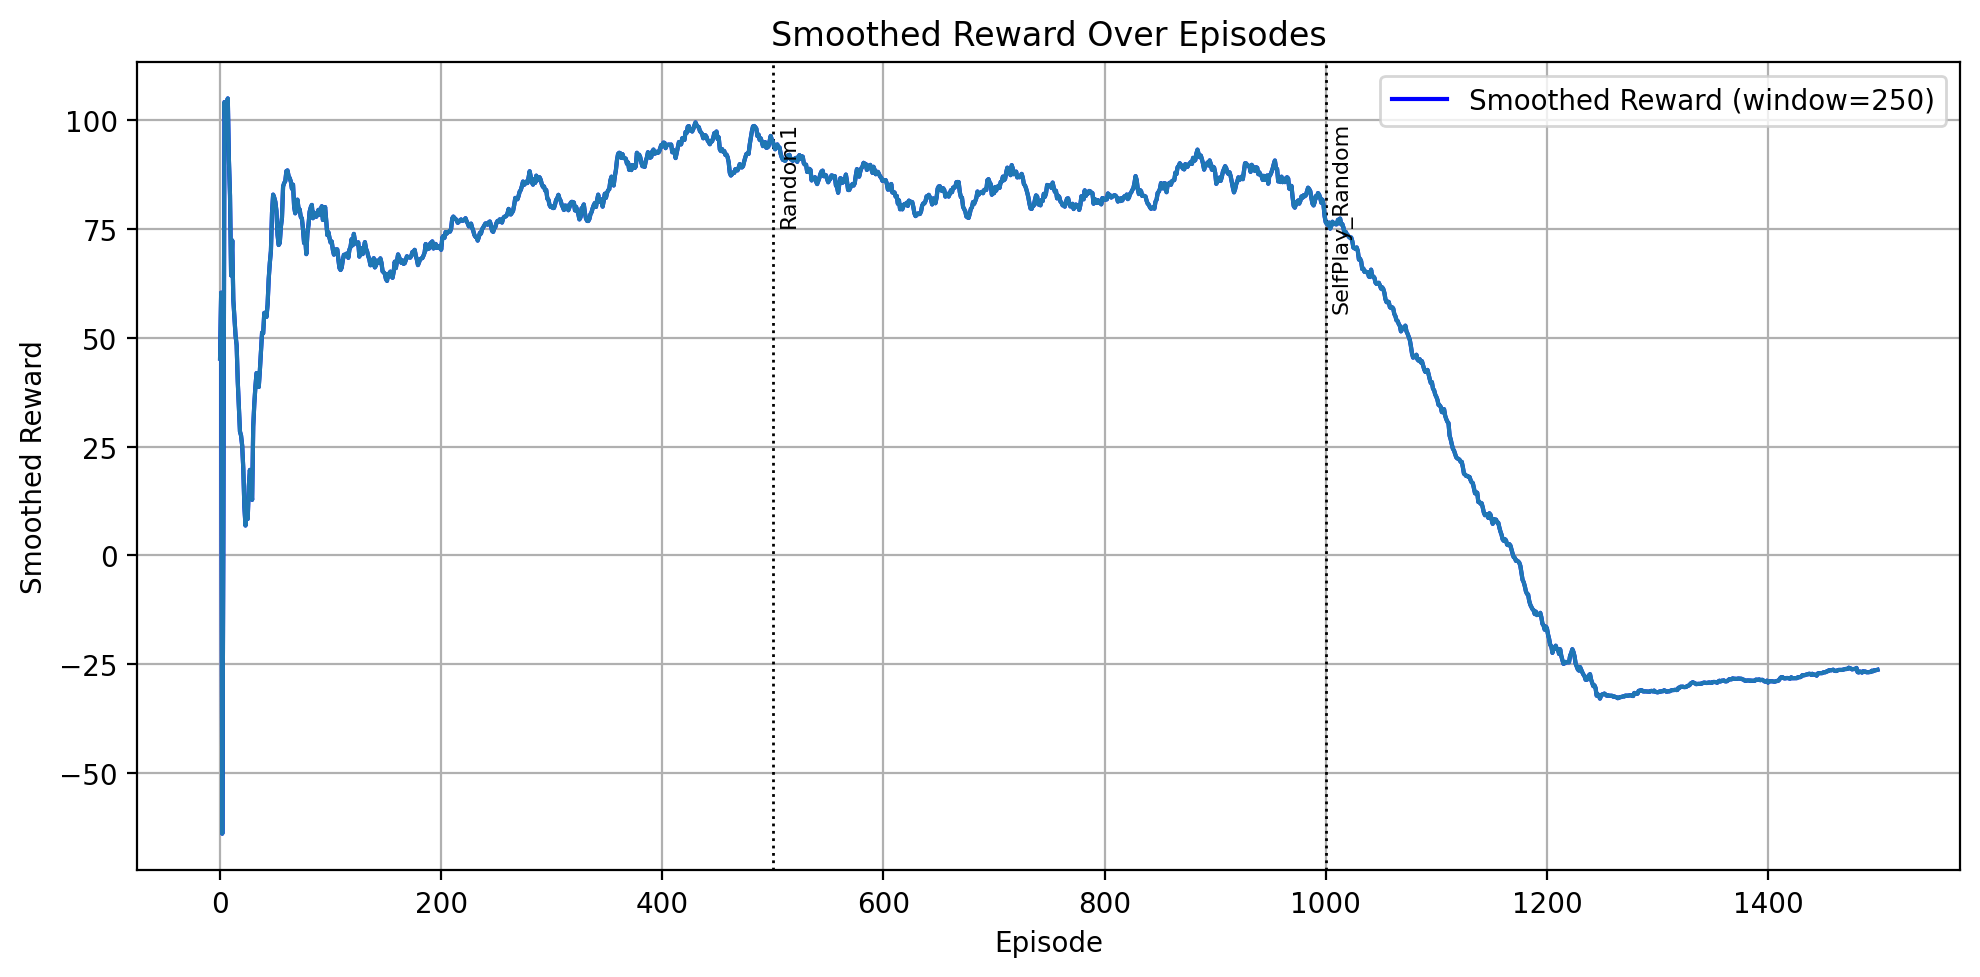

In [12]:
window = 250
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name,
                             rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

plt.plot(smoothed)
plt.show()

In [13]:
df_summary = pd.DataFrame.from_dict(summary_stats, orient="index")
df_summary.to_excel(f"{LOG_DIR}PPO-{TRAINING_SESSION}_summary.xlsx", index=True)

## Save model

In [14]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 ppo_model_{timestamp} episodes-{number_episodes} lookahead-{lookahead_depth}.pt"
default_model_path = "Connect4 PPQ model.pt"   

model_path, default_model_path = save_checkpoint(
    policy=policy,
    optim=optim,
    episode=episode,
    lookahead_depth=lookahead_depth,
    cfg=cfg,
    hparams=hparams,
    model_path=model_path,
    default_model_path=default_model_path,
)
print(f"Model saved to {model_path}\nAlso wrote: {default_model_path}")

Model saved to Models/PPQ/PPQ-1500-SelfPlay sanity_Connect4 ppo_model_20250819-135020 episodes-1500 lookahead-1.pt
Also wrote: Connect4 PPQ model.pt


## Reload model

In [15]:
load_path = "Connect4 PPQ model.pt"  # EXACT
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    loaded_model, loaded_optim_state, meta = load_checkpoint(load_path, device=DEVICE)

loaded_model.eval()
print(f"Model successfully loaded from {load_path}")
if meta:
    print(f"  meta: episode={meta.get('episode')}, lk={meta.get('lookahead_depth')} ts={meta.get('timestamp')}")


Model successfully loaded from Connect4 PPQ model.pt
  meta: episode=1500, lk=1 ts=20250819-135020


# Evaluation

In [16]:
# === PPO EVALUATION ===
#assert 'loaded_model' in globals(), "loaded_model not found. Load your model first."

# --- Config ---
evaluation_opponents = {
    "Random": 200,
    "Lookahead-1": 100,
    "Lookahead-2": 10,
    "Lookahead-3": 10,   # raise later if you want
    # "Lookahead-5": 10,
    # "Lookahead-7": 5,
}

TEMPERATURE_EVAL = 0.0     # greedy

# Fresh env + lookahead
eval_env = Connect4Env()
look_eval = Connect4Lookahead()

evaluation_results = {}
start_time = time.time()

with torch.inference_mode():
    for label, num_games in evaluation_opponents.items():
        wins = losses = draws = 0
        depth = int(label.split("-")[1]) if label.startswith("Lookahead") else None

        with tqdm(total=num_games, desc=f"Opponent: {label}") as pbar:
            for game_index in range(num_games):
                state = eval_env.reset()

                # --- Alternate who starts; agent is ALWAYS +1 ---
                agent_starts = (game_index % 2 == 0)
                eval_env.current_player = 1 if agent_starts else -1
                done = False

                while not done:
                    if eval_env.current_player == 1:
                        # Agent move (greedy)
                        legal_actions = eval_env.available_actions()
                        if not legal_actions:  # extremely rare
                            draws += 1
                            break
                        action, _, _, _ = loaded_model.act(
                            state.astype(np.float32),
                            legal_actions=legal_actions,
                            temperature=TEMPERATURE_EVAL
                        )
                    else:
                        # Opponent move
                        legal_actions = eval_env.available_actions()
                        if label == "Random":
                            action = random.choice(legal_actions)
                        else:
                            a = look_eval.n_step_lookahead(np.array(state), player=-1, depth=depth)
                            action = a if a in legal_actions else random.choice(legal_actions)

                    # Step env
                    state, _, done = eval_env.step(action)

                # --- Tally result (agent is +1) ---
                if eval_env.winner == 1:
                    wins += 1
                elif eval_env.winner == -1:
                    losses += 1
                else:
                    draws += 1

                pbar.update(1)

        evaluation_results[label] = {
            "wins": wins,
            "losses": losses,
            "draws": draws,
            "win_rate": round(wins / num_games, 3),
            "loss_rate": round(losses / num_games, 3),
            "draw_rate": round(draws / num_games, 3),
        }

elapsed = time.time() - start_time
print(f"Evaluation completed in {elapsed/60:.1f} minutes\n")

Opponent: Lookahead-3: 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]

Evaluation completed in 1.3 minutes



📊 Evaluation Summary:
     Random: 165W / 35L / 0D → Win 82.5% | Loss 17.5% | Draw 0.0%
Lookahead-1: 0W / 100L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%
Lookahead-2: 0W / 10L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%
Lookahead-3: 0W / 10L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%


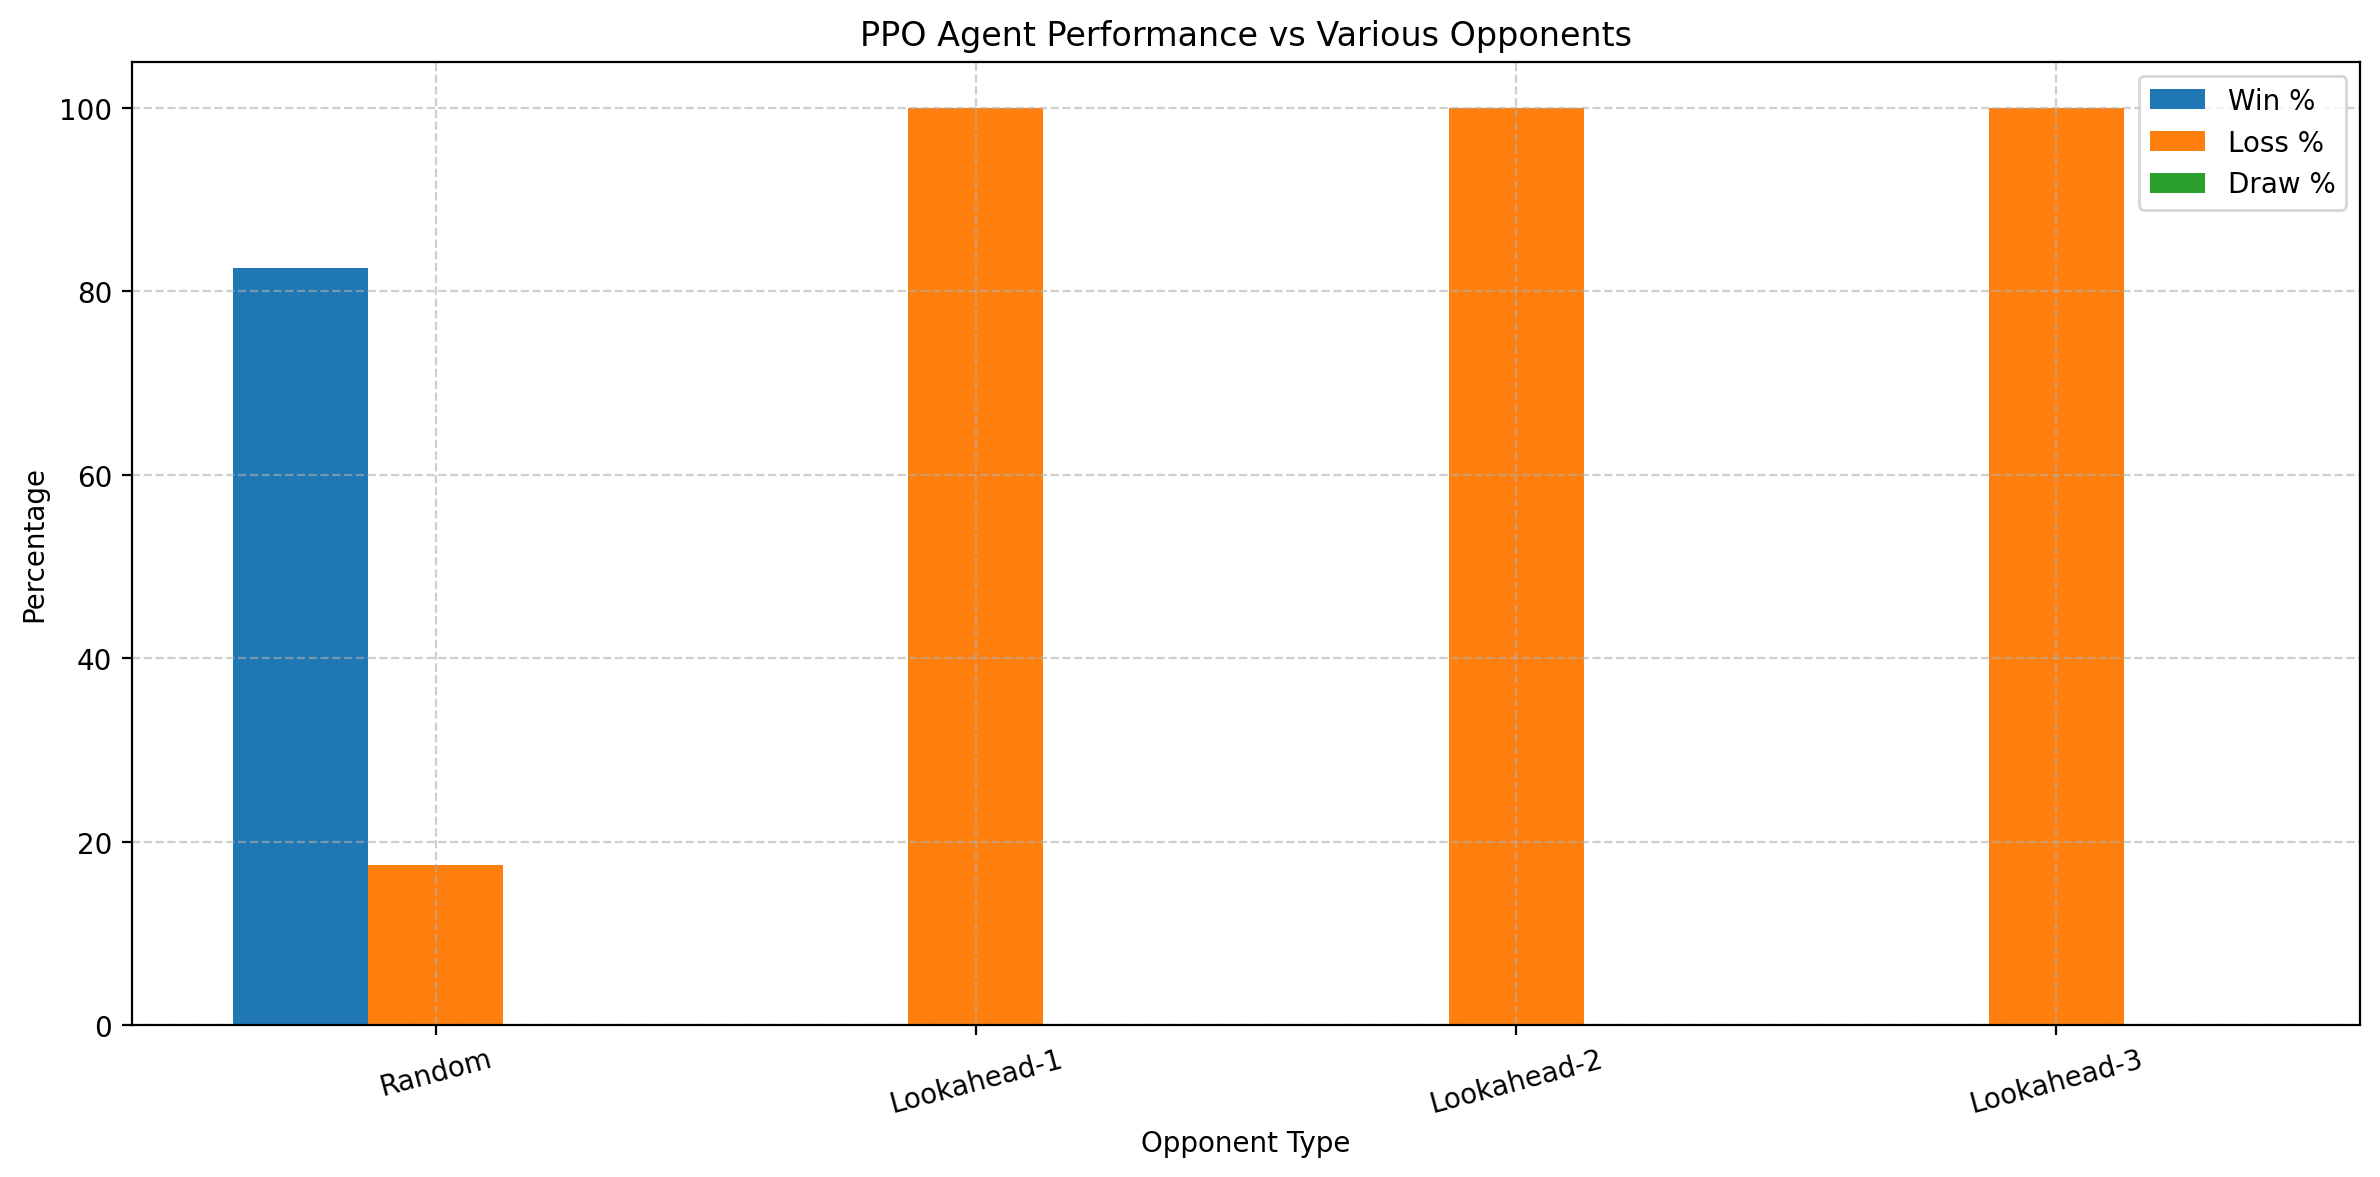

Evaluation results saved to Logs/PPQ/PPQ-1500-SelfPlay sanity_PPO_evaluation_results.xlsx


In [17]:
# --- Text summary ---
print("📊 Evaluation Summary:")
for label, s in evaluation_results.items():
    print(f"{label:>11}: {s['wins']}W / {s['losses']}L / {s['draws']}D → "
          f"Win {s['win_rate']*100:.1f}% | Loss {s['loss_rate']*100:.1f}% | Draw {s['draw_rate']*100:.1f}%")

# --- Plot ---
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate'] * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = np.arange(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar(x + bar_width, loss_rates, width=bar_width, label='Loss %')
plt.bar(x + 2*bar_width, draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('PPO Agent Performance vs Various Opponents')
plt.xticks(x + bar_width, labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Save evaluation table to Excel ---
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"
save_path = f"{LOG_DIR}{TRAINING_SESSION}_PPO_evaluation_results.xlsx"
os.makedirs(LOG_DIR, exist_ok=True)
df_eval.to_excel(save_path, index=True)
print(f"Evaluation results saved to {save_path}")

# DONE

In [18]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.1 hours


## Training log

In [19]:
# TRAINING_SESSION

training_log_file = "PPO Training_Sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": number_episodes}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: PPO Training_Sessions.xlsx
